# Convolutional Neural Network from Scratch

Computational Intelligence  - STRATEGOS  UNIGE

A. Cabri & F. Masulli

modified from https://github.com/eriklindernoren/ML-From-Scratch by 
Erik Linder-Norén

Here we will implement a CNN using numpy only.

We will test it on a small size data set.

## Required imports

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import math
import numpy as np
from __future__ import print_function, division
from terminaltables import AsciiTable
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import copy
import sys


## Utils

In [2]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]


def batch_iterator(X, y=None, batch_size=64):
    """ Simple batch generator """
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]


def divide_on_feature(X, feature_i, threshold):
    """ Divide dataset based on if sample value on feature index is larger than
        the given threshold """
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])


def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new


def get_random_subsets(X, y, n_subsets, replacements=True):
    """ Return random subsets (with replacements) of the data """
    n_samples = np.shape(X)[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
    np.random.shuffle(X_y)
    subsets = []

    # Uses 50% of training samples without replacements
    subsample_size = int(n_samples // 2)
    if replacements:
        subsample_size = n_samples      # 100% with replacements

    for _ in range(n_subsets):
        idx = np.random.choice(
            range(n_samples),
            size=np.shape(range(subsample_size)),
            replace=replacements)
        X = X_y[idx][:, :-1]
        y = X_y[idx][:, -1]
        subsets.append([X, y])
    return subsets


def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test


def k_fold_cross_validation_sets(X, y, k, shuffle=True):
    """ Split the data into k sets of training / test data """
    if shuffle:
        X, y = shuffle_data(X, y)

    n_samples = len(y)
    left_overs = {}
    n_left_overs = (n_samples % k)
    if n_left_overs != 0:
        left_overs["X"] = X[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        X = X[:-n_left_overs]
        y = y[:-n_left_overs]

    X_split = np.split(X, k)
    y_split = np.split(y, k)
    sets = []
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        sets.append([X_train, X_test, y_train, y_test])

    # Add left over samples to last set as training samples
    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["X"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return np.array(sets)


def to_categorical(x, n_col=None):
    """ One-hot encoding of nominal values """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot


def to_nominal(x):
    """ Conversion from one-hot encoding to nominal """
    return np.argmax(x, axis=1)


def make_diagonal(x):
    """ Converts a vector into an diagonal matrix """
    m = np.zeros((len(x), len(x)))
    for i in range(len(m[0])):
        m[i, i] = x[i]
    return m

## Other utils

In [3]:
bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()



## Statistical Indeces

In [4]:
def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy


def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse


def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


def calculate_std_dev(X):
    """ Calculate the standard deviations of the features in dataset X """
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev


def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)


def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)



# Optimizers

Optimizers for models that use gradient based methods for finding the weights that minimizes the loss.

A great resource for understanding these methods:
https://ruder.io/optimizing-gradient-descent/


In [5]:

class StochasticGradientDescent():
    def __init__(self, learning_rate=0.01, momentum=0):
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.w_updt = None

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.w_updt is None:
            self.w_updt = np.zeros(np.shape(w))
        # Use momentum if set
        self.w_updt = self.momentum * self.w_updt + (1 - self.momentum) * grad_wrt_w
        # Move against the gradient to minimize loss
        return w - self.learning_rate * self.w_updt

class NesterovAcceleratedGradient():
    def __init__(self, learning_rate=0.001, momentum=0.4):
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.w_updt = np.array([])

    def update(self, w, grad_func):
        # Calculate the gradient of the loss a bit further down the slope from w
        approx_future_grad = np.clip(grad_func(w - self.momentum * self.w_updt), -1, 1)
        # Initialize on first update
        if not self.w_updt.any():
            self.w_updt = np.zeros(np.shape(w))

        self.w_updt = self.momentum * self.w_updt + self.learning_rate * approx_future_grad
        # Move against the gradient to minimize loss
        return w - self.w_updt

class Adagrad():
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.G = None # Sum of squares of the gradients
        self.eps = 1e-8

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.G is None:
            self.G = np.zeros(np.shape(w))
        # Add the square of the gradient of the loss function at w
        self.G += np.power(grad_wrt_w, 2)
        # Adaptive gradient with higher learning rate for sparse data
        return w - self.learning_rate * grad_wrt_w / np.sqrt(self.G + self.eps)

class Adadelta():
    def __init__(self, rho=0.95, eps=1e-6):
        self.E_w_updt = None # Running average of squared parameter updates
        self.E_grad = None   # Running average of the squared gradient of w
        self.w_updt = None   # Parameter update
        self.eps = eps
        self.rho = rho

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.w_updt is None:
            self.w_updt = np.zeros(np.shape(w))
            self.E_w_updt = np.zeros(np.shape(w))
            self.E_grad = np.zeros(np.shape(grad_wrt_w))

        # Update average of gradients at w
        self.E_grad = self.rho * self.E_grad + (1 - self.rho) * np.power(grad_wrt_w, 2)
        
        RMS_delta_w = np.sqrt(self.E_w_updt + self.eps)
        RMS_grad = np.sqrt(self.E_grad + self.eps)

        # Adaptive learning rate
        adaptive_lr = RMS_delta_w / RMS_grad

        # Calculate the update
        self.w_updt = adaptive_lr * grad_wrt_w

        # Update the running average of w updates
        self.E_w_updt = self.rho * self.E_w_updt + (1 - self.rho) * np.power(self.w_updt, 2)

        return w - self.w_updt

class RMSprop():
    def __init__(self, learning_rate=0.01, rho=0.9):
        self.learning_rate = learning_rate
        self.Eg = None # Running average of the square gradients at w
        self.eps = 1e-8
        self.rho = rho

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.Eg is None:
            self.Eg = np.zeros(np.shape(grad_wrt_w))

        self.Eg = self.rho * self.Eg + (1 - self.rho) * np.power(grad_wrt_w, 2)

        # Divide the learning rate for a weight by a running average of the magnitudes of recent
        # gradients for that weight
        return w - self.learning_rate *  grad_wrt_w / np.sqrt(self.Eg + self.eps)

class Adam():
    def __init__(self, learning_rate=0.001, b1=0.9, b2=0.999):
        self.learning_rate = learning_rate
        self.eps = 1e-8
        self.m = None
        self.v = None
        # Decay rates
        self.b1 = b1
        self.b2 = b2

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.m is None:
            self.m = np.zeros(np.shape(grad_wrt_w))
            self.v = np.zeros(np.shape(grad_wrt_w))
        
        self.m = self.b1 * self.m + (1 - self.b1) * grad_wrt_w
        self.v = self.b2 * self.v + (1 - self.b2) * np.power(grad_wrt_w, 2)

        m_hat = self.m / (1 - self.b1)
        v_hat = self.v / (1 - self.b2)

        self.w_updt = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)

        return w - self.w_updt



# Activation functions

Reference: https://en.wikipedia.org/wiki/Activation_function


<img src="af1.png" width="800"/>

<img src="af2.png" width="800"/>


In [6]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class Softmax():
    def __call__(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        p = self.__call__(x)
        return p * (1 - p)

class TanH():
    def __call__(self, x):
        return 2 / (1 + np.exp(-2*x)) - 1

    def gradient(self, x):
        return 1 - np.power(self.__call__(x), 2)

class ReLU():
    def __call__(self, x):
        return np.where(x >= 0, x, 0)

    def gradient(self, x):
        return np.where(x >= 0, 1, 0)

class LeakyReLU():
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x):
        return np.where(x >= 0, x, self.alpha * x)

    def gradient(self, x):
        return np.where(x >= 0, 1, self.alpha)

class ELU():
    def __init__(self, alpha=0.1):
        self.alpha = alpha 

    def __call__(self, x):
        return np.where(x >= 0.0, x, self.alpha * (np.exp(x) - 1))

    def gradient(self, x):
        return np.where(x >= 0.0, 1, self.__call__(x) + self.alpha)

class SELU():
    # Reference : https://arxiv.org/abs/1706.02515,
    # https://github.com/bioinf-jku/SNNs/blob/master/TF_1_x/SelfNormalizingNetworks_MLP_MNIST.ipynb
    def __init__(self):
        self.alpha = 1.6732632423543772848170429916717
        self.scale = 1.0507009873554804934193349852946 

    def __call__(self, x):
        return self.scale * np.where(x >= 0.0, x, self.alpha*(np.exp(x)-1))

    def gradient(self, x):
        return self.scale * np.where(x >= 0.0, 1, self.alpha * np.exp(x))

class SoftPlus():
    def __call__(self, x):
        return np.log(1 + np.exp(x))

    def gradient(self, x):
        return 1 / (1 + np.exp(-x))


## Loss Functions

In [7]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)



## Layers

In [8]:
class Layer(object):

    def set_input_shape(self, shape):
        """ Sets the shape that the layer expects of the input in the forward
        pass method """
        self.input_shape = shape

    def layer_name(self):
        """ The name of the layer. Used in model summary. """
        return self.__class__.__name__

    def parameters(self):
        """ The number of trainable parameters used by the layer """
        return 0

    def forward_pass(self, X, training):
        """ Propogates the signal forward in the network """
        raise NotImplementedError()

    def backward_pass(self, accum_grad):
        """ Propogates the accumulated gradient backwards in the network.
        If the has trainable weights then these weights are also tuned in this method.
        As input (accum_grad) it receives the gradient with respect to the output of the layer and
        returns the gradient with respect to the output of the previous layer. """
        raise NotImplementedError()

    def output_shape(self):
        """ The shape of the output produced by forward_pass """
        raise NotImplementedError()


class Dense(Layer):
    """A fully-connected NN layer.
    Parameters:
    -----------
    n_units: int
        The number of neurons in the layer.
    input_shape: tuple
        The expected input shape of the layer. For dense layers a single digit specifying
        the number of features of the input. Must be specified if it is the first layer in
        the network.
    """
    def __init__(self, n_units, input_shape=None):
        self.layer_input = None
        self.input_shape = input_shape
        self.n_units = n_units
        self.trainable = True
        self.W = None
        self.w0 = None

    def initialize(self, optimizer):
        # Initialize the weights
        limit = 1 / math.sqrt(self.input_shape[0])
        self.W  = np.random.uniform(-limit, limit, (self.input_shape[0], self.n_units))
        self.w0 = np.zeros((1, self.n_units))
        # Weight optimizers
        self.W_opt  = copy.copy(optimizer)
        self.w0_opt = copy.copy(optimizer)

    def parameters(self):
        return np.prod(self.W.shape) + np.prod(self.w0.shape)

    def forward_pass(self, X, training=True):
        self.layer_input = X
        return X.dot(self.W) + self.w0

    def backward_pass(self, accum_grad):
        # Save weights used during forwards pass
        W = self.W

        if self.trainable:
            # Calculate gradient w.r.t layer weights
            grad_w = self.layer_input.T.dot(accum_grad)
            grad_w0 = np.sum(accum_grad, axis=0, keepdims=True)

            # Update the layer weights
            self.W = self.W_opt.update(self.W, grad_w)
            self.w0 = self.w0_opt.update(self.w0, grad_w0)

        # Return accumulated gradient for next layer
        # Calculated based on the weights used during the forward pass
        accum_grad = accum_grad.dot(W.T)
        return accum_grad

    def output_shape(self):
        return (self.n_units, )


class RNN(Layer):
    """A Vanilla Fully-Connected Recurrent Neural Network layer.

    Parameters:
    -----------
    n_units: int
        The number of hidden states in the layer.
    activation: string
        The name of the activation function which will be applied to the output of each state.
    bptt_trunc: int
        Decides how many time steps the gradient should be propagated backwards through states
        given the loss gradient for time step t.
    input_shape: tuple
        The expected input shape of the layer. For dense layers a single digit specifying
        the number of features of the input. Must be specified if it is the first layer in
        the network.

    Reference:
    https://programmerclick.com/article/6151597327/
    """
    def __init__(self, n_units, activation='tanh', bptt_trunc=5, input_shape=None):
        self.input_shape = input_shape
        self.n_units = n_units
        self.activation = activation_functions[activation]()
        self.trainable = True
        self.bptt_trunc = bptt_trunc
        self.W = None # Weight of the previous state
        self.V = None # Weight of the output
        self.U = None # Weight of the input

    def initialize(self, optimizer):
        timesteps, input_dim = self.input_shape
        # Initialize the weights
        limit = 1 / math.sqrt(input_dim)
        self.U  = np.random.uniform(-limit, limit, (self.n_units, input_dim))
        limit = 1 / math.sqrt(self.n_units)
        self.V = np.random.uniform(-limit, limit, (input_dim, self.n_units))
        self.W  = np.random.uniform(-limit, limit, (self.n_units, self.n_units))
        # Weight optimizers
        self.U_opt  = copy.copy(optimizer)
        self.V_opt = copy.copy(optimizer)
        self.W_opt = copy.copy(optimizer)

    def parameters(self):
        return np.prod(self.W.shape) + np.prod(self.U.shape) + np.prod(self.V.shape)

    def forward_pass(self, X, training=True):
        self.layer_input = X
        batch_size, timesteps, input_dim = X.shape

        # Save these values for use in backprop.
        self.state_input = np.zeros((batch_size, timesteps, self.n_units))
        self.states = np.zeros((batch_size, timesteps+1, self.n_units))
        self.outputs = np.zeros((batch_size, timesteps, input_dim))

        # Set last time step to zero for calculation of the state_input at time step zero
        self.states[:, -1] = np.zeros((batch_size, self.n_units))
        for t in range(timesteps):
            # Input to state_t is the current input and output of previous states
            self.state_input[:, t] = X[:, t].dot(self.U.T) + self.states[:, t-1].dot(self.W.T)
            self.states[:, t] = self.activation(self.state_input[:, t])
            self.outputs[:, t] = self.states[:, t].dot(self.V.T)

        return self.outputs

    def backward_pass(self, accum_grad):
        _, timesteps, _ = accum_grad.shape

        # Variables where we save the accumulated gradient w.r.t each parameter
        grad_U = np.zeros_like(self.U)
        grad_V = np.zeros_like(self.V)
        grad_W = np.zeros_like(self.W)
        # The gradient w.r.t the layer input.
        # Will be passed on to the previous layer in the network
        accum_grad_next = np.zeros_like(accum_grad)

        # Back Propagation Through Time
        for t in reversed(range(timesteps)):
            # Update gradient w.r.t V at time step t
            grad_V += accum_grad[:, t].T.dot(self.states[:, t])
            # Calculate the gradient w.r.t the state input
            grad_wrt_state = accum_grad[:, t].dot(self.V) * self.activation.gradient(self.state_input[:, t])
            # Gradient w.r.t the layer input
            accum_grad_next[:, t] = grad_wrt_state.dot(self.U)
            # Update gradient w.r.t W and U by backprop. from time step t for at most
            # self.bptt_trunc number of time steps
            for t_ in reversed(np.arange(max(0, t - self.bptt_trunc), t+1)):
                grad_U += grad_wrt_state.T.dot(self.layer_input[:, t_])
                grad_W += grad_wrt_state.T.dot(self.states[:, t_-1])
                # Calculate gradient w.r.t previous state
                grad_wrt_state = grad_wrt_state.dot(self.W) * self.activation.gradient(self.state_input[:, t_-1])

        # Update weights
        self.U = self.U_opt.update(self.U, grad_U)
        self.V = self.V_opt.update(self.V, grad_V)
        self.W = self.W_opt.update(self.W, grad_W)

        return accum_grad_next

    def output_shape(self):
        return self.input_shape

class Conv2D(Layer):
    """A 2D Convolution Layer.

    Parameters:
    -----------
    n_filters: int
        The number of filters that will convolve over the input matrix. The number of channels
        of the output shape.
    filter_shape: tuple
        A tuple (filter_height, filter_width).
    input_shape: tuple
        The shape of the expected input of the layer. (batch_size, channels, height, width)
        Only needs to be specified for first layer in the network.
    padding: string
        Either 'same' or 'valid'. 'same' results in padding being added so that the output height and width
        matches the input height and width. For 'valid' no padding is added.
    stride: int
        The stride length of the filters during the convolution over the input.
    """
    def __init__(self, n_filters, filter_shape, input_shape=None, padding='same', stride=1):
        self.n_filters = n_filters
        self.filter_shape = filter_shape
        self.padding = padding
        self.stride = stride
        self.input_shape = input_shape
        self.trainable = True

    def initialize(self, optimizer):
        # Initialize the weights
        filter_height, filter_width = self.filter_shape
        channels = self.input_shape[0]
        limit = 1 / math.sqrt(np.prod(self.filter_shape))
        self.W  = np.random.uniform(-limit, limit, size=(self.n_filters, channels, filter_height, filter_width))
        self.w0 = np.zeros((self.n_filters, 1))
        # Weight optimizers
        self.W_opt  = copy.copy(optimizer)
        self.w0_opt = copy.copy(optimizer)

    def parameters(self):
        return np.prod(self.W.shape) + np.prod(self.w0.shape)

    def forward_pass(self, X, training=True):
        batch_size, channels, height, width = X.shape
        self.layer_input = X
        # Turn image shape into column shape
        # (enables dot product between input and weights)
        self.X_col = image_to_column(X, self.filter_shape, stride=self.stride, output_shape=self.padding)
        # Turn weights into column shape
        self.W_col = self.W.reshape((self.n_filters, -1))
        # Calculate output
        output = self.W_col.dot(self.X_col) + self.w0
        # Reshape into (n_filters, out_height, out_width, batch_size)
        output = output.reshape(self.output_shape() + (batch_size, ))
        # Redistribute axises so that batch size comes first
        return output.transpose(3,0,1,2)

    def backward_pass(self, accum_grad):
        # Reshape accumulated gradient into column shape
        accum_grad = accum_grad.transpose(1, 2, 3, 0).reshape(self.n_filters, -1)

        if self.trainable:
            # Take dot product between column shaped accum. gradient and column shape
            # layer input to determine the gradient at the layer with respect to layer weights
            grad_w = accum_grad.dot(self.X_col.T).reshape(self.W.shape)
            # The gradient with respect to bias terms is the sum similarly to in Dense layer
            grad_w0 = np.sum(accum_grad, axis=1, keepdims=True)

            # Update the layers weights
            self.W = self.W_opt.update(self.W, grad_w)
            self.w0 = self.w0_opt.update(self.w0, grad_w0)

        # Recalculate the gradient which will be propagated back to prev. layer
        accum_grad = self.W_col.T.dot(accum_grad)
        # Reshape from column shape to image shape
        accum_grad = column_to_image(accum_grad,
                                self.layer_input.shape,
                                self.filter_shape,
                                stride=self.stride,
                                output_shape=self.padding)

        return accum_grad

    def output_shape(self):
        channels, height, width = self.input_shape
        pad_h, pad_w = determine_padding(self.filter_shape, output_shape=self.padding)
        output_height = (height + np.sum(pad_h) - self.filter_shape[0]) / self.stride + 1
        output_width = (width + np.sum(pad_w) - self.filter_shape[1]) / self.stride + 1
        return self.n_filters, int(output_height), int(output_width)


class BatchNormalization(Layer):
    """Batch normalization.
    """
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.trainable = True
        self.eps = 0.01
        self.running_mean = None
        self.running_var = None

    def initialize(self, optimizer):
        # Initialize the parameters
        self.gamma  = np.ones(self.input_shape)
        self.beta = np.zeros(self.input_shape)
        # parameter optimizers
        self.gamma_opt  = copy.copy(optimizer)
        self.beta_opt = copy.copy(optimizer)

    def parameters(self):
        return np.prod(self.gamma.shape) + np.prod(self.beta.shape)

    def forward_pass(self, X, training=True):

        # Initialize running mean and variance if first run
        if self.running_mean is None:
            self.running_mean = np.mean(X, axis=0)
            self.running_var = np.var(X, axis=0)

        if training and self.trainable:
            mean = np.mean(X, axis=0)
            var = np.var(X, axis=0)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            mean = self.running_mean
            var = self.running_var

        # Statistics saved for backward pass
        self.X_centered = X - mean
        self.stddev_inv = 1 / np.sqrt(var + self.eps)

        X_norm = self.X_centered * self.stddev_inv
        output = self.gamma * X_norm + self.beta

        return output

    def backward_pass(self, accum_grad):

        # Save parameters used during the forward pass
        gamma = self.gamma

        # If the layer is trainable the parameters are updated
        if self.trainable:
            X_norm = self.X_centered * self.stddev_inv
            grad_gamma = np.sum(accum_grad * X_norm, axis=0)
            grad_beta = np.sum(accum_grad, axis=0)

            self.gamma = self.gamma_opt.update(self.gamma, grad_gamma)
            self.beta = self.beta_opt.update(self.beta, grad_beta)

        batch_size = accum_grad.shape[0]

        # The gradient of the loss with respect to the layer inputs (use weights and statistics from forward pass)
        accum_grad = (1 / batch_size) * gamma * self.stddev_inv * (
            batch_size * accum_grad
            - np.sum(accum_grad, axis=0)
            - self.X_centered * self.stddev_inv**2 * np.sum(accum_grad * self.X_centered, axis=0)
            )

        return accum_grad

    def output_shape(self):
        return self.input_shape


class PoolingLayer(Layer):
    """A parent class of MaxPooling2D and AveragePooling2D
    """
    def __init__(self, pool_shape=(2, 2), stride=1, padding=0):
        self.pool_shape = pool_shape
        self.stride = stride
        self.padding = padding
        self.trainable = True

    def forward_pass(self, X, training=True):
        self.layer_input = X

        batch_size, channels, height, width = X.shape

        _, out_height, out_width = self.output_shape()

        X = X.reshape(batch_size*channels, 1, height, width)
        X_col = image_to_column(X, self.pool_shape, self.stride, self.padding)

        # MaxPool or AveragePool specific method
        output = self._pool_forward(X_col)

        output = output.reshape(out_height, out_width, batch_size, channels)
        output = output.transpose(2, 3, 0, 1)

        return output

    def backward_pass(self, accum_grad):
        batch_size, _, _, _ = accum_grad.shape
        channels, height, width = self.input_shape
        accum_grad = accum_grad.transpose(2, 3, 0, 1).ravel()

        # MaxPool or AveragePool specific method
        accum_grad_col = self._pool_backward(accum_grad)

        accum_grad = column_to_image(accum_grad_col, (batch_size * channels, 1, height, width), self.pool_shape, self.stride, 0)
        accum_grad = accum_grad.reshape((batch_size,) + self.input_shape)

        return accum_grad

    def output_shape(self):
        channels, height, width = self.input_shape
        out_height = (height - self.pool_shape[0]) / self.stride + 1
        out_width = (width - self.pool_shape[1]) / self.stride + 1
        assert out_height % 1 == 0
        assert out_width % 1 == 0
        return channels, int(out_height), int(out_width)


class MaxPooling2D(PoolingLayer):
    def _pool_forward(self, X_col):
        arg_max = np.argmax(X_col, axis=0).flatten()
        output = X_col[arg_max, range(arg_max.size)]
        self.cache = arg_max
        return output

    def _pool_backward(self, accum_grad):
        accum_grad_col = np.zeros((np.prod(self.pool_shape), accum_grad.size))
        arg_max = self.cache
        accum_grad_col[arg_max, range(accum_grad.size)] = accum_grad
        return accum_grad_col

class AveragePooling2D(PoolingLayer):
    def _pool_forward(self, X_col):
        output = np.mean(X_col, axis=0)
        return output

    def _pool_backward(self, accum_grad):
        accum_grad_col = np.zeros((np.prod(self.pool_shape), accum_grad.size))
        accum_grad_col[:, range(accum_grad.size)] = 1. / accum_grad_col.shape[0] * accum_grad
        return accum_grad_col


class ConstantPadding2D(Layer):
    """Adds rows and columns of constant values to the input.
    Expects the input to be of shape (batch_size, channels, height, width)

    Parameters:
    -----------
    padding: tuple
        The amount of padding along the height and width dimension of the input.
        If (pad_h, pad_w) the same symmetric padding is applied along height and width dimension.
        If ((pad_h0, pad_h1), (pad_w0, pad_w1)) the specified padding is added to beginning and end of
        the height and width dimension.
    padding_value: int or tuple
        The value the is added as padding.
    """
    def __init__(self, padding, padding_value=0):
        self.padding = padding
        self.trainable = True
        if not isinstance(padding[0], tuple):
            self.padding = ((padding[0], padding[0]), padding[1])
        if not isinstance(padding[1], tuple):
            self.padding = (self.padding[0], (padding[1], padding[1]))
        self.padding_value = padding_value

    def forward_pass(self, X, training=True):
        output = np.pad(X,
            pad_width=((0,0), (0,0), self.padding[0], self.padding[1]),
            mode="constant",
            constant_values=self.padding_value)
        return output

    def backward_pass(self, accum_grad):
        pad_top, pad_left = self.padding[0][0], self.padding[1][0]
        height, width = self.input_shape[1], self.input_shape[2]
        accum_grad = accum_grad[:, :, pad_top:pad_top+height, pad_left:pad_left+width]
        return accum_grad

    def output_shape(self):
        new_height = self.input_shape[1] + np.sum(self.padding[0])
        new_width = self.input_shape[2] + np.sum(self.padding[1])
        return (self.input_shape[0], new_height, new_width)


class ZeroPadding2D(ConstantPadding2D):
    """Adds rows and columns of zero values to the input.
    Expects the input to be of shape (batch_size, channels, height, width)

    Parameters:
    -----------
    padding: tuple
        The amount of padding along the height and width dimension of the input.
        If (pad_h, pad_w) the same symmetric padding is applied along height and width dimension.
        If ((pad_h0, pad_h1), (pad_w0, pad_w1)) the specified padding is added to beginning and end of
        the height and width dimension.
    """
    def __init__(self, padding):
        self.padding = padding
        if isinstance(padding[0], int):
            self.padding = ((padding[0], padding[0]), padding[1])
        if isinstance(padding[1], int):
            self.padding = (self.padding[0], (padding[1], padding[1]))
        self.padding_value = 0


class Flatten(Layer):
    """ Turns a multidimensional matrix into two-dimensional """
    def __init__(self, input_shape=None):
        self.prev_shape = None
        self.trainable = True
        self.input_shape = input_shape

    def forward_pass(self, X, training=True):
        self.prev_shape = X.shape
        return X.reshape((X.shape[0], -1))

    def backward_pass(self, accum_grad):
        return accum_grad.reshape(self.prev_shape)

    def output_shape(self):
        return (np.prod(self.input_shape),)


class UpSampling2D(Layer):
    """ Nearest neighbor up sampling of the input. Repeats the rows and
    columns of the data by size[0] and size[1] respectively.

    Parameters:
    -----------
    size: tuple
        (size_y, size_x) - The number of times each axis will be repeated.
    """
    def __init__(self, size=(2,2), input_shape=None):
        self.prev_shape = None
        self.trainable = True
        self.size = size
        self.input_shape = input_shape

    def forward_pass(self, X, training=True):
        self.prev_shape = X.shape
        # Repeat each axis as specified by size
        X_new = X.repeat(self.size[0], axis=2).repeat(self.size[1], axis=3)
        return X_new

    def backward_pass(self, accum_grad):
        # Down sample input to previous shape
        accum_grad = accum_grad[:, :, ::self.size[0], ::self.size[1]]
        return accum_grad

    def output_shape(self):
        channels, height, width = self.input_shape
        return channels, self.size[0] * height, self.size[1] * width


class Reshape(Layer):
    """ Reshapes the input tensor into specified shape

    Parameters:
    -----------
    shape: tuple
        The shape which the input shall be reshaped to.
    """
    def __init__(self, shape, input_shape=None):
        self.prev_shape = None
        self.trainable = True
        self.shape = shape
        self.input_shape = input_shape

    def forward_pass(self, X, training=True):
        self.prev_shape = X.shape
        return X.reshape((X.shape[0], ) + self.shape)

    def backward_pass(self, accum_grad):
        return accum_grad.reshape(self.prev_shape)

    def output_shape(self):
        return self.shape


class Dropout(Layer):
    """A layer that randomly sets a fraction p of the output units of the previous layer
    to zero.

    Parameters:
    -----------
    p: float
        The probability that unit x is set to zero.
    """
    def __init__(self, p=0.2):
        self.p = p
        self._mask = None
        self.input_shape = None
        self.n_units = None
        self.pass_through = True
        self.trainable = True

    def forward_pass(self, X, training=True):
        c = (1 - self.p)
        if training:
            self._mask = np.random.uniform(size=X.shape) > self.p
            c = self._mask
        return X * c

    def backward_pass(self, accum_grad):
        return accum_grad * self._mask

    def output_shape(self):
        return self.input_shape

activation_functions = {
    'relu': ReLU,
    'sigmoid': Sigmoid,
    'selu': SELU,
    'elu': ELU,
    'softmax': Softmax,
    'leaky_relu': LeakyReLU,
    'tanh': TanH,
    'softplus': SoftPlus
}

class Activation(Layer):
    """A layer that applies an activation operation to the input.

    Parameters:
    -----------
    name: string
        The name of the activation function that will be used.
    """

    def __init__(self, name):
        self.activation_name = name
        self.activation_func = activation_functions[name]()
        self.trainable = True

    def layer_name(self):
        return "Activation (%s)" % (self.activation_func.__class__.__name__)

    def forward_pass(self, X, training=True):
        self.layer_input = X
        return self.activation_func(X)

    def backward_pass(self, accum_grad):
        return accum_grad * self.activation_func.gradient(self.layer_input)

    def output_shape(self):
        return self.input_shape


# Method which calculates the padding based on the specified output shape and the
# shape of the filters
def determine_padding(filter_shape, output_shape="same"):

    # No padding
    if output_shape == "valid":
        return (0, 0), (0, 0)
    # Pad so that the output shape is the same as input shape (given that stride=1)
    elif output_shape == "same":
        filter_height, filter_width = filter_shape

        # Derived from:
        # output_height = (height + pad_h - filter_height) / stride + 1
        # In this case output_height = height and stride = 1. This gives the
        # expression for the padding below.
        pad_h1 = int(math.floor((filter_height - 1)/2))
        pad_h2 = int(math.ceil((filter_height - 1)/2))
        pad_w1 = int(math.floor((filter_width - 1)/2))
        pad_w2 = int(math.ceil((filter_width - 1)/2))

        return (pad_h1, pad_h2), (pad_w1, pad_w2)


# Reference: CS231n Stanford
def get_im2col_indices(images_shape, filter_shape, padding, stride=1):
    # First figure out what the size of the output should be
    batch_size, channels, height, width = images_shape
    filter_height, filter_width = filter_shape
    pad_h, pad_w = padding
    out_height = int((height + np.sum(pad_h) - filter_height) / stride + 1)
    out_width = int((width + np.sum(pad_w) - filter_width) / stride + 1)

    i0 = np.repeat(np.arange(filter_height), filter_width)
    i0 = np.tile(i0, channels)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(filter_width), filter_height * channels)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(channels), filter_height * filter_width).reshape(-1, 1)

    return (k, i, j)


# Method which turns the image shaped input to column shape.
# Used during the forward pass.
# Reference: CS231n Stanford
def image_to_column(images, filter_shape, stride, output_shape='same'):
    filter_height, filter_width = filter_shape

    pad_h, pad_w = determine_padding(filter_shape, output_shape)

    # Add padding to the image
    images_padded = np.pad(images, ((0, 0), (0, 0), pad_h, pad_w), mode='constant')

    # Calculate the indices where the dot products are to be applied between weights
    # and the image
    k, i, j = get_im2col_indices(images.shape, filter_shape, (pad_h, pad_w), stride)

    # Get content from image at those indices
    cols = images_padded[:, k, i, j]
    channels = images.shape[1]
    # Reshape content into column shape
    cols = cols.transpose(1, 2, 0).reshape(filter_height * filter_width * channels, -1)
    return cols



# Method which turns the column shaped input to image shape.
# Used during the backward pass.
# Reference: CS231n Stanford
def column_to_image(cols, images_shape, filter_shape, stride, output_shape='same'):
    batch_size, channels, height, width = images_shape
    pad_h, pad_w = determine_padding(filter_shape, output_shape)
    height_padded = height + np.sum(pad_h)
    width_padded = width + np.sum(pad_w)
    images_padded = np.zeros((batch_size, channels, height_padded, width_padded))

    # Calculate the indices where the dot products are applied between weights
    # and the image
    k, i, j = get_im2col_indices(images_shape, filter_shape, (pad_h, pad_w), stride)

    cols = cols.reshape(channels * np.prod(filter_shape), -1, batch_size)
    cols = cols.transpose(2, 0, 1)
    # Add column content to the images at the indices
    np.add.at(images_padded, (slice(None), k, i, j), cols)

    # Return image without padding
    return images_padded[:, :, pad_h[0]:height+pad_h[0], pad_w[0]:width+pad_w[0]]



In [9]:
class NeuralNetwork():
    """Neural Network. Deep Learning base model.

    Parameters:
    -----------
    optimizer: class
        The weight optimizer that will be used to tune the weights in order of minimizing
        the loss.
    loss: class
        Loss function used to measure the model's performance. SquareLoss or CrossEntropy.
    validation: tuple
        A tuple containing validation data and labels (X, y)
    """
    def __init__(self, optimizer, loss, validation_data=None):
        self.optimizer = optimizer
        self.layers = []
        self.errors = {"training": [], "validation": []}
        self.loss_function = loss()
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        self.val_set = None
        if validation_data:
            X, y = validation_data
            self.val_set = {"X": X, "y": y}

    def set_trainable(self, trainable):
        """ Method which enables freezing of the weights of the network's layers. """
        for layer in self.layers:
            layer.trainable = trainable

    def add(self, layer):
        """ Method which adds a layer to the neural network """
        # If this is not the first layer added then set the input shape
        # to the output shape of the last added layer
        if self.layers:
            layer.set_input_shape(shape=self.layers[-1].output_shape())

        # If the layer has weights that needs to be initialized 
        if hasattr(layer, 'initialize'):
            layer.initialize(optimizer=self.optimizer)

        # Add layer to the network
        self.layers.append(layer)

    def test_on_batch(self, X, y):
        """ Evaluates the model over a single batch of samples """
        y_pred = self._forward_pass(X, training=False)
        loss = np.mean(self.loss_function.loss(y, y_pred))
        acc = self.loss_function.acc(y, y_pred)

        return loss, acc

    def train_on_batch(self, X, y):
        """ Single gradient update over one batch of samples """
        y_pred = self._forward_pass(X)
        loss = np.mean(self.loss_function.loss(y, y_pred))
        acc = self.loss_function.acc(y, y_pred)
        # Calculate the gradient of the loss function wrt y_pred
        loss_grad = self.loss_function.gradient(y, y_pred)
        # Backpropagate. Update weights
        self._backward_pass(loss_grad=loss_grad)

        return loss, acc

    def fit(self, X, y, n_epochs, batch_size):
        """ Trains the model for a fixed number of epochs """
        for _ in self.progressbar(range(n_epochs)):
            
            batch_error = []
            for X_batch, y_batch in batch_iterator(X, y, batch_size=batch_size):
                loss, _ = self.train_on_batch(X_batch, y_batch)
                batch_error.append(loss)

            self.errors["training"].append(np.mean(batch_error))

            if self.val_set is not None:
                val_loss, _ = self.test_on_batch(self.val_set["X"], self.val_set["y"])
                self.errors["validation"].append(val_loss)

        return self.errors["training"], self.errors["validation"]

    def _forward_pass(self, X, training=True):
        """ Calculate the output of the NN """
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward_pass(layer_output, training)

        return layer_output

    def _backward_pass(self, loss_grad):
        """ Propagate the gradient 'backwards' and update the weights in each layer """
        for layer in reversed(self.layers):
            loss_grad = layer.backward_pass(loss_grad)

    def summary(self, name="Model Summary"):
        # Print model name
        print (AsciiTable([[name]]).table)
        # Network input shape (first layer's input shape)
        print ("Input Shape: %s" % str(self.layers[0].input_shape))
        # Iterate through network and get each layer's configuration
        table_data = [["Layer Type", "Parameters", "Output Shape"]]
        tot_params = 0
        for layer in self.layers:
            layer_name = layer.layer_name()
            params = layer.parameters()
            out_shape = layer.output_shape()
            table_data.append([layer_name, str(params), str(out_shape)])
            tot_params += params
        # Print network configuration table
        print (AsciiTable(table_data).table)
        print ("Total Parameters: %d\n" % tot_params)

    def predict(self, X):
        """ Use the trained model to predict labels of X """
        return self._forward_pass(X, training=False)

## Optical recognition of handwritten digits dataset

UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.

* Data Set Characteristics:
* Number of Instances: 1797
* Number of Attributes: 64
* Attribute Information: 8x8 image of integer pixels in the range 0..16.


Preprocessing programs made available by NIST were used to extract normalized bitmaps of handwritten digits from a preprinted form. 

From a total of 43 people, 30 contributed to the training set and different 13 to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of 4x4 and the number of on pixels are counted in each block. This generates an input matrix of 8x8 where each element is an integer in the range 0..16. This reduces dimensionality and gives invariance to small distortions.

Reference: Alpaydin, C. Kaynak (1998) Cascading Classifiers, Kybernetika.


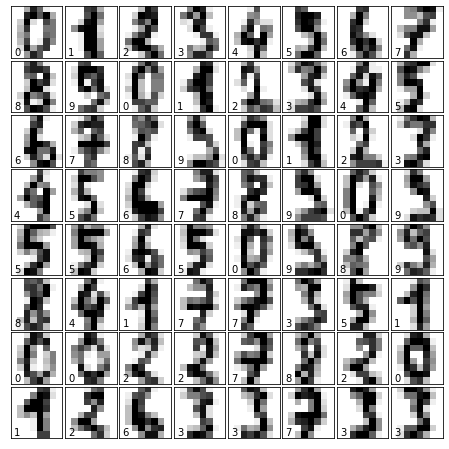

In [10]:
data = datasets.load_digits() 
    # The datasets.load_digits() function helps to load and return the 
    # digit dataset. This classification contains data points, where each 
    # data point is an 8X8 image of a single digit.

    
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(data.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(data.target[i]))


+---------+
| ConvNet |
+---------+
Input Shape: (1, 8, 8)
+----------------------+------------+--------------+
| Layer Type           | Parameters | Output Shape |
+----------------------+------------+--------------+
| Conv2D               | 160        | (16, 8, 8)   |
| Activation (ReLU)    | 0          | (16, 8, 8)   |
| Dropout              | 0          | (16, 8, 8)   |
| BatchNormalization   | 2048       | (16, 8, 8)   |
| Conv2D               | 4640       | (32, 8, 8)   |
| Activation (ReLU)    | 0          | (32, 8, 8)   |
| Dropout              | 0          | (32, 8, 8)   |
| BatchNormalization   | 4096       | (32, 8, 8)   |
| Flatten              | 0          | (2048,)      |
| Dense                | 524544     | (256,)       |
| Activation (ReLU)    | 0          | (256,)       |
| Dropout              | 0          | (256,)       |
| BatchNormalization   | 512        | (256,)       |
| Dense                | 2570       | (10,)        |
| Activation (Softmax) | 0          | (

Training: 100% [------------------------------------------------] Time: 0:03:04


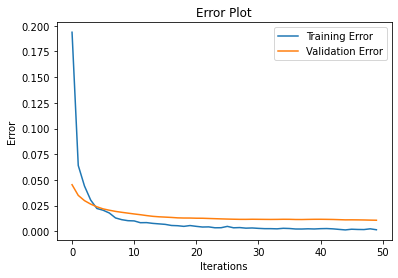

Accuracy: 0.9846796657381616


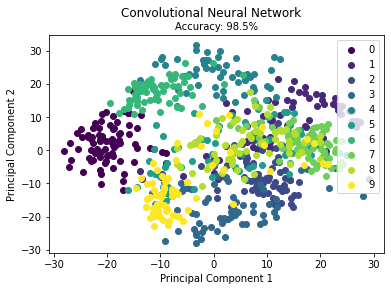

In [11]:
def main():
    #----------
    # Conv Net
    #----------

    optimizer = Adam()
   
    X = data.data
    y = data.target

    # Convert to one-hot encoding
    y = to_categorical(y.astype("int"))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=1)

    # Reshape X to (n_samples, channels, height, width)
    X_train = X_train.reshape((-1,1,8,8))
    X_test = X_test.reshape((-1,1,8,8))

    clf = NeuralNetwork(optimizer=optimizer,
                        loss=CrossEntropy,
                        validation_data=(X_test, y_test))

    clf.add(Conv2D(n_filters=16, filter_shape=(3,3), stride=1, input_shape=(1,8,8), padding='same'))
                # padding ='same' results in padding being added so that the 
                # output height and width matches the input height and width. 
    clf.add(Activation('relu'))
    clf.add(Dropout(0.25))
    clf.add(BatchNormalization())
    clf.add(Conv2D(n_filters=32, filter_shape=(3,3), stride=1, padding='same'))
    clf.add(Activation('relu'))
    clf.add(Dropout(0.25))
    clf.add(BatchNormalization())
    clf.add(Flatten())
    clf.add(Dense(256))
    clf.add(Activation('relu'))
    clf.add(Dropout(0.4))
    clf.add(BatchNormalization())
    clf.add(Dense(10))
    clf.add(Activation('softmax'))

    print ()
    clf.summary(name="ConvNet")

    train_err, val_err = clf.fit(X_train, y_train, n_epochs=50, batch_size=256)

    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot")
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()

    _, accuracy = clf.test_on_batch(X_test, y_test)
    print ("Accuracy:", accuracy)


    y_pred = np.argmax(clf.predict(X_test), axis=1)
    X_test = X_test.reshape(-1, 8*8)
    # Reduce dimension to 2D using PCA and plot the results
    Plot().plot_in_2d(X_test, y_pred, title="Convolutional Neural Network", accuracy=accuracy, legend_labels=range(10))

if __name__ == "__main__":
    main()